In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abreualberto91/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
df = pd.read_json('reviews_Automotive_5.json', lines=True)
df.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400


# Data Preprocessing

Data preprocessing and cleaning is an important step before any text mining task, in this step, we will remove the punctuations, stopwords and normalize the reviews as much as possible. After every preprocessing step, it is a good practice to check the most frequent words in the data. Therefore, let’s define a function that would plot a bar graph of n most frequent words in the data

In [31]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
    all_words = ' '.join([text for text in x])
    print(all_words[:10])
    all_words = all_words.split()
    print(all_words[:10])

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    print(words_df.head())
    print()
    
  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    print(d.head())
    plt.figure(figsize=(20,8))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

I needed a
['I', 'needed', 'a', 'set', 'of', 'jumper', 'cables', 'for', 'my', 'new']
     word  count
0       I  43185
1  needed    787
2       a  45091
3     set    973
4      of  24606

   word  count
83  the  82515
11  and  48720
31   to  48522
2     a  45091
0     I  43185


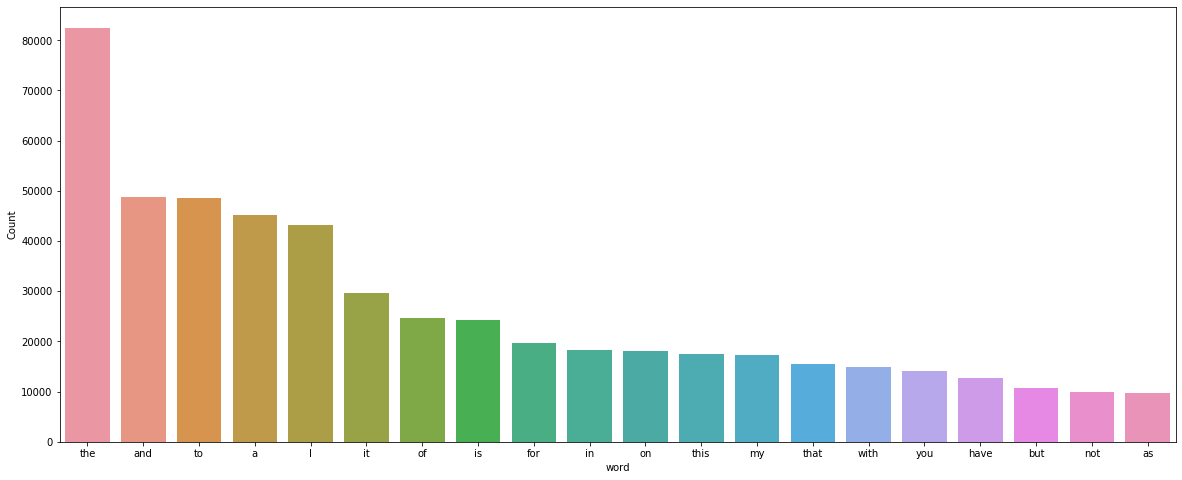

In [32]:
freq_words(df['reviewText'])

**Most common words are ‘the’, ‘and’, ‘to’, so on and so forth. These words are not so important for our task and they do not tell any story. We’ have to get rid of these kinds of words. Before that let’s remove the punctuations and numbers from our text data.**

In [33]:
# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [34]:
df['reviewText'].iloc[0]

'I needed a set of jumper cables for my new car and these had good reviews and were at a good price   They have been used a few times already and do what they are supposed to   no complaints there What I will say is that    feet really isn t an ideal length   Sure  if you pull up front bumper to front bumper they are plenty long  but a lot of times you will be beside another car or can t get really close   Because of this  I would recommend something a little longer than     Great brand   get     version though '

In [35]:
#Let’s try to remove the stopwords and short words (<2 letters) from the reviews.

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

In [38]:
reviews[0]

'needed set jumper cables new car good reviews good price they used times already supposed complaints what say feet really ideal length sure pull front bumper front bumper plenty long lot times beside another car get really close because would recommend something little longer great brand get version though'

**Let’s again plot the most frequent words and see if the more significant words have come out.**

needed set
['needed', 'set', 'jumper', 'cables', 'new', 'car', 'good', 'reviews', 'good', 'price']
     word  count
0  needed   1124
1     set   1195
2  jumper     80
3  cables    316
4     new   2219

     word  count
178   the   9984
76    use   8201
5     car   8030
175   one   7362
318  this   6303


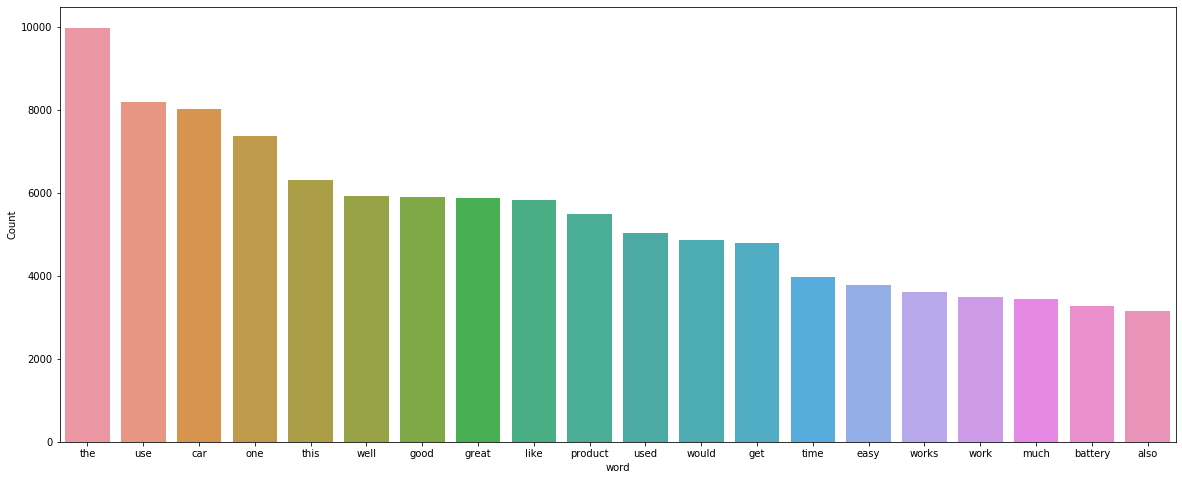

In [40]:
freq_words(reviews, 20)

**We can see some improvement here. Terms like ‘battery’, ‘price’, ‘product’, ‘oil’ have come up which are quite relevant for the Automotive category. However, we still have neutral terms like ‘the’, ‘this’, ‘much’, ‘they’ which are not that relevant.**

To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [45]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
        output = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            output.append([token.lemma_ for token in doc if token.pos_ in tags])
        return output

**Let’s tokenize the reviews and then lemmatize the tokenized reviews.**

In [46]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [47]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


**As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized reviews and plot the most common words.**

set jumper
['set', 'jumper', 'new', 'car', 'good', 'review', 'good', 'price', 'time', 'complaint']
     word  count
0     set    495
1  jumper     90
2     new   2359
3     car   9494
4    good   9100

        word  count
3        car   9494
4       good   9100
300  product   6921
21     great   5388
40       use   4955


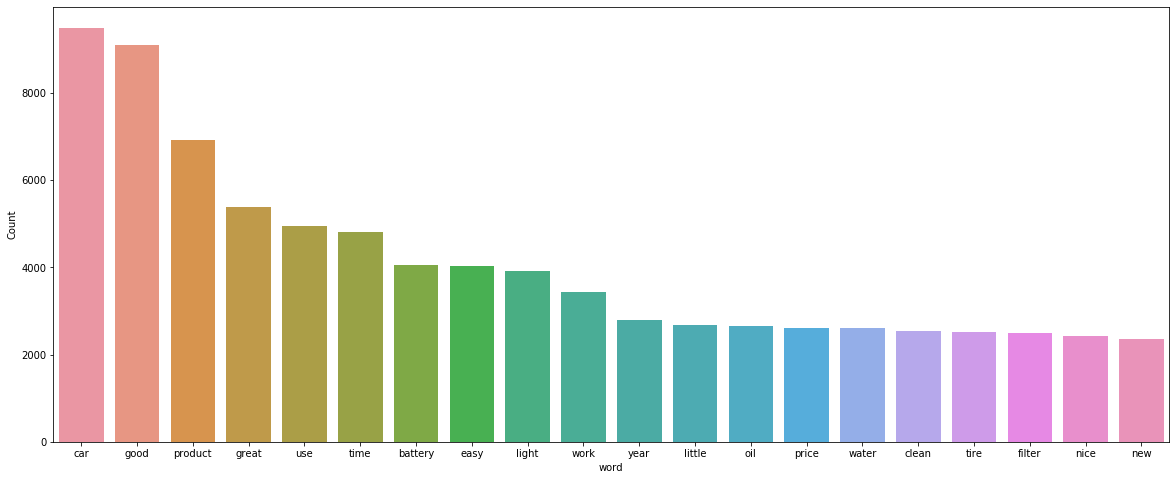

In [48]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 20)

**It seems that now most frequent terms in our data are relevant. We can now go ahead and start building our topic model.**

# Building an LDA model

We will start by creating the term dictionary of our corpus, where every unique term is assigned an index

In [49]:
dictionary = corpora.Dictionary(reviews_2)

In [61]:
first10pairs = {x: dictionary[x] for x in list(dictionary)[:10]}
first10pairs

{0: 'brand',
 1: 'bumper',
 2: 'car',
 3: 'close',
 4: 'complaint',
 5: 'foot',
 6: 'front',
 7: 'good',
 8: 'great',
 9: 'ideal'}

**Then we will convert the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.**

In [71]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]
doc_term_matrix[0][1:3]

[(1, 2), (2, 2)]

In [72]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [73]:
lda_model.print_topics()

[(0,
  '0.020*"oil" + 0.020*"good" + 0.015*"car" + 0.014*"filter" + 0.013*"product" + 0.010*"price" + 0.010*"engine" + 0.009*"change" + 0.009*"time" + 0.009*"water"'),
 (1,
  '0.055*"leather" + 0.039*"tire" + 0.038*"wheel" + 0.024*"clean" + 0.022*"seat" + 0.021*"brush" + 0.020*"mat" + 0.015*"smell" + 0.013*"product" + 0.013*"board"'),
 (2,
  '0.046*"car" + 0.034*"product" + 0.025*"towel" + 0.024*"good" + 0.016*"wax" + 0.015*"water" + 0.014*"use" + 0.014*"great" + 0.012*"time" + 0.012*"clean"'),
 (3,
  '0.051*"blade" + 0.042*"wiper" + 0.018*"windshield" + 0.015*"good" + 0.014*"rain" + 0.013*"car" + 0.011*"snow" + 0.011*"window" + 0.011*"year" + 0.010*"bosch"'),
 (4,
  '0.015*"good" + 0.013*"easy" + 0.012*"use" + 0.012*"hose" + 0.011*"great" + 0.010*"small" + 0.009*"work" + 0.009*"little" + 0.009*"nice" + 0.008*"plastic"'),
 (5,
  '0.064*"light" + 0.030*"bulb" + 0.020*"bright" + 0.014*"good" + 0.013*"white" + 0.012*"great" + 0.011*"headlight" + 0.010*"color" + 0.010*"easy" + 0.010*"insta

**The fourth topic Topic 3 has terms like ‘towel’, ‘clean’, ‘wax’, ‘water’, indicating that the topic is very much related to car-wash. Similarly, Topic 6 seems to be about the overall value of the product as it has terms like ‘price’, ‘quality’, and ‘worth’.**

# Topics Visualization

To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [74]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

KeyboardInterrupt: 